- **Author:** [Dace Apšvalka](https://www.mrc-cbu.cam.ac.uk/people/dace.apsvalka/) 
- **Date:** August 2024  
- **conda environment**: I used the [fMRI workshop's conda environment](https://github.com/MRC-CBU/COGNESTIC/blob/main/mri_environment.yml) to run this notebook and any accompanied scripts.

# Neuroimaging data manipulation

Adapted from:
- https://carpentries-incubator.github.io/SDC-BIDS-IntroMRI/anatomy-of-nifti.html and 
- https://github.com/miykael/workshop_pybrain

We'll be exploring two libraries: [NiBabel](http://nipy.org/nibabel/) and [Nilearn](https://nilearn.github.io/stable/index.html). 

**NiBabel** gives read and write access to common neuroimaging file formats. NiBabel’s API gives full or selective access to header information (metadata), and image data is made available via NumPy arrays.

"**Nilearn** enables **approachable and versatile analyses of brain volumes**. It provides statistical and machine-learning tools, with instructive documentation & open community. It supports general linear model (GLM) based analysis and leverages the scikit-learn Python toolbox for multivariate statistics with applications such as predictive modelling, classification, decoding, or connectivity analysis."

----------

**Table of contents**<a id='toc0_'></a>    
1. [Setup](#toc1_)    
2. [Loading and inspecting images in `nibabel`](#toc2_)    
2.1. [Header](#toc2_1_)    
2.2. [Data](#toc2_2_)    
2.3. [Affine](#toc2_3_)    
3. [Image manipulation with `nilearn`](#toc3_)    
3.1. [The mean image](#toc3_1_)    
3.2. [Resample image to a template](#toc3_2_)    
3.3. [Smooth an image](#toc3_3_)    
3.4. [Plotting a time course](#toc3_4_)    
3.5. [Masking an image](#toc3_5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=3
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

-------

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [56]:
import nibabel as nib

from nilearn import plotting
from nilearn import image as nli

import matplotlib.pyplot as plt
import pylab as plt

import numpy as np
## Set numpy to print 3 decimal points and suppress small values
np.set_printoptions(precision=3, suppress=True)

## 2. <a id='toc2_'></a>[Loading and inspecting images in `nibabel`](#toc0_)

First, we will use the `load()` function to create a `NiBabel` image object from a NIfTI file. 

We’ll load in an example `T1w` and `BOLD` images that we will retrieve from our `BIDS` dataset.


In [57]:
from bids.layout import BIDSLayout

fmri_data_dir = 'FaceProcessing/data'

# Initialize the BIDS layout
layout = BIDSLayout(fmri_data_dir)

# Get subject's T1w image and all Bold images
t1_file = layout.get(subject='04', extension='nii.gz', datatype='anat', return_type='filename')
bold_files = layout.get(subject='04', extension='nii.gz', suffix='bold', return_type='filename')

# Load the T1 image and the 1st Bold image
t1_img = nib.load(t1_file[0])
bold_img = nib.load(bold_files[0])

# Print the shape of both images
print(f"The shape of the T1 image: {t1_img.shape}")
print(f"The shape of the Bold image: {bold_img.shape}")

The shape of the T1 image: (192, 256, 256)
The shape of the Bold image: (64, 64, 33, 210)


Loading in a NIfTI file with `NiBabel` gives us a special type of data object which encodes all the information in the file. Each bit of information is called an attribute in Python’s terminology. To see all of these attributes, type `t1_img.` followed by pressing `Tab`. There are three main attributes that we’ll discuss today:
* `Header`
* `Data`
* `Affine`

### 2.1. <a id='toc2_1_'></a>[Header](#toc0_)
`Header` contains metadata about the image, such as image dimensions, data type, etc.

In [58]:
t1_hdr = t1_img.header
print(t1_hdr)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 54
dim             : [  3 192 256 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.   1.   1.   1.   2.25 0.   0.   0.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'TE=3;Time=165059.315;phase=1'
aux_file        : b'V'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -91.432205
qoffset_y       : -108.694916
qoffset_z       

`t1_hdr` is a Python **dictionary**. Dictionaries are containers that hold pairs of objects - **keys** and **values**. 
We can access the value stored by a given key by typing: `t1_hdr['<key_name>']`.

In [59]:
t1_hdr['magic']

array(b'n+1', dtype='|S4')

**==================================================================================================**

**EXCERCISE**

Extract `pixdim` value from the `BOLD image` header.

In [60]:
# write your code here


**==================================================================================================**

### 2.2. <a id='toc2_2_'></a>[Data](#toc0_)

As you’ve seen above, the header contains valuable metadata about the MR data we’ve loaded. Now, we'll move on to loading the actual image data itself. This can be done using the `get_fdata()` method.

In [61]:
# Get the T1 and Bold image data
t1_data = t1_img.get_fdata()
bold_data = bold_img.get_fdata()

# How does the T1 data look like
print(t1_data)

[[[27. 22. 19. ...  0.  1.  0.]
  [13. 22. 14. ...  2.  2.  0.]
  [ 9. 19.  8. ...  2.  3.  0.]
  ...
  [ 8.  0.  2. ...  4.  2.  0.]
  [10.  2.  3. ...  4.  2.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[14. 13. 29. ...  5.  4.  0.]
  [14. 19.  9. ...  2.  0.  0.]
  [22. 19. 22. ...  3.  1.  0.]
  ...
  [ 2.  8.  8. ...  3.  3.  0.]
  [ 5. 10. 11. ...  1.  2.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[15. 20. 10. ...  2.  1.  0.]
  [24. 18.  8. ...  3.  2.  0.]
  [23. 14.  9. ...  1.  1.  0.]
  ...
  [ 2. 11.  0. ...  1.  1.  0.]
  [ 2.  4.  0. ...  2.  3.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 ...

 [[15.  3.  3. ...  3.  1.  0.]
  [18. 16.  3. ...  2.  2.  0.]
  [ 3.  3.  5. ...  3.  0.  0.]
  ...
  [ 0.  8.  4. ...  0.  0.  0.]
  [ 1.  1.  4. ...  2.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[29.  6. 27. ...  1.  4.  0.]
  [23.  4. 14. ...  3.  3.  0.]
  [ 1. 10. 15. ...  3.  0.  0.]
  ...
  [ 5.  0.  2. ...  0.  2.  0.]
  [ 3.  5.  9. ...  2.  2.  0.]
  [ 0.  0.  0. ...  0.  0.  

The data is a **multidimensional array** representing the image.

How can we check the number of dimensions in the t1_data array? You can view all the available attributes by typing `t1_data.` and then pressing `Tab`.

In [62]:
# T1 number of dimensions
print(f"T1w image dimensions: {t1_data.ndim}")

T1w image dimensions: 3


**==================================================================================================**

**EXCERCISE**

What's the imensions of our BOLD image?

In [63]:
# write your code here


**==================================================================================================**

In [64]:
# How large each dimension is
print(f"T1w image shape is {t1_data.shape}")
print(f"BOLD image shape is {bold_data.shape}")

T1w image shape is (192, 256, 256)
BOLD image shape is (64, 64, 33, 210)


The first 3 numbers given here represent the number of values along a respective dimension *(x,y,z)*. For the `BOLD` image this brain was scanned in `33` axial slices with a resolution of `64 x 64` voxels per slice. That means there are:

`64 * 64 * 33 = 135,168` voxels in total. And the BOLD signal was sampled `208` times. 

Let’s see the type of data inside of the array.


How do we examine **what value a particular voxel is**? We can inspect the value of a voxel by selecting an index as follows:

`data[x,y,z]`

So for example we can inspect a voxel at coordinates `(20,60,50)` by doing the following:

In [65]:
# A value of a T1 image voxel at coordinates (20,60,50)
t1_data[19, 59, 49]

6.0

**NOTE**: Python uses **zero-based indexing**. The first item in the array is item `0`. The second item is item `1`, the third is item `2`, etc.

We can also extract data from a **slice** for visualisation and analysis. Slicing does exactly what it sounds like: from our 3D volume, we extract a 2D slice of the data. Below is an example of slicing from left to right (sagittal slicing, along the x-axis). In this case, we'll view the 20th slice.

In [66]:
# Values of the T1 image's 20th sagittal slice
x_slice = t1_data[19, :, :]
print(x_slice)

[[12. 19. 29. ...  2.  5.  0.]
 [24. 26. 24. ...  1.  2.  0.]
 [34. 43.  2. ...  0.  3.  0.]
 ...
 [10. 11. 11. ...  2.  3.  0.]
 [13.  3. 10. ...  4.  3.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


This is similar to the indexing we did before to pull out a single voxel. However, instead of providing a value for each axis, the `:` indicates that we want to grab all values from that particular axis.

In [67]:
z_slice = t1_data[:, :, 2]
print(z_slice)

[[19. 14.  8. ...  2.  3.  0.]
 [29.  9. 22. ...  8. 11.  0.]
 [10.  8.  9. ...  0.  0.  0.]
 ...
 [ 3.  3.  5. ...  4.  4.  0.]
 [27. 14. 15. ...  2.  9.  0.]
 [ 7. 16. 39. ...  7.  7.  0.]]


We’ve been looking at voxel nummerical values, but we have no idea what the images actually look like! Let's look how the `100` slice of each of the `3` dimensions of T1 image look. 

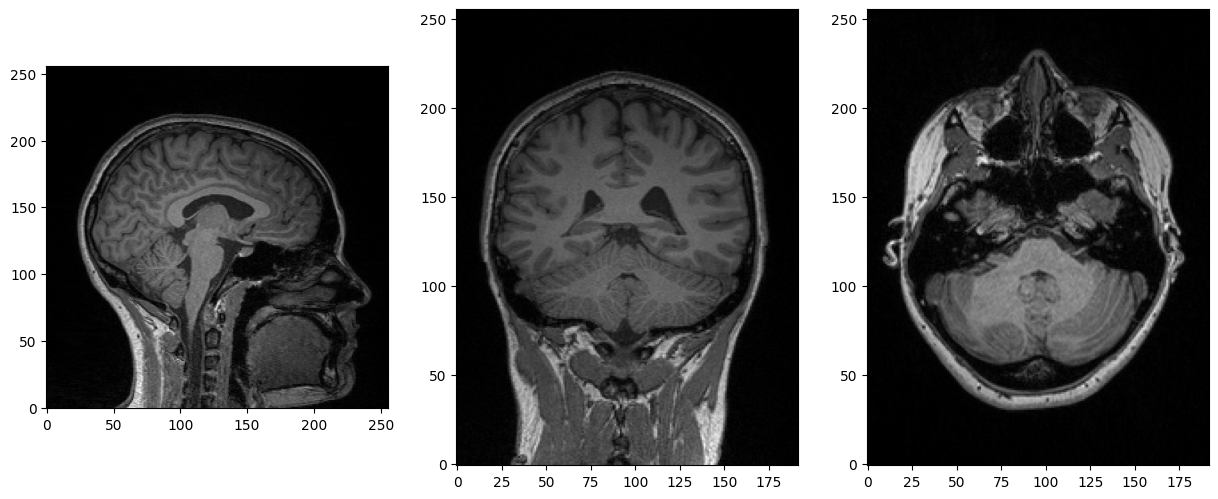

In [68]:
%matplotlib inline

slices = [t1_data[99, :, :], t1_data[:, 99, :], t1_data[:, :, 99]]

fig, axes = plt.subplots(1, len(slices), figsize=(15,15))
for i, slice in enumerate(slices):
    axes[i].imshow(slice.T, cmap="gray", origin="lower")


`Nibabel` has its own viewer, which can be accessed through `img.orthoview()`.

**Sidenote to plotting with orthoview()**

As with other figures, if you initiated `matplotlib` with `%matplotlib inline`, the output figure will be static. If you use `orthoview()` in a normal IPython console, it will create an interactive window, and you can click to select different slices, similar to `mricron`. To get a similar experience in a `jupyter notebook`, use `%matplotlib notebook`. **But don't forget to close figures afterward again or use` %matplotlib inline` again, otherwise, you cannot plot any other figures.**

In [69]:
%matplotlib notebook
t1_img.orthoview()

<IPython.core.display.Javascript object>

<OrthoSlicer3D: /imaging/correia/da05/workshops/2024-09-COGNESTIC/fMRI/FaceProcessing/data/sub-04/anat/sub-04_T1w.nii.gz (192, 256, 256)>

### 2.3. <a id='toc2_3_'></a>[Affine](#toc0_)

The final important piece of metadata associated with an image file is the **affine matrix**. The affine matrix defines the position of the image data in a reference space.

A voxel coordinate by itself tells us very little about where the data originates within the scanner. For example, if we have the voxel coordinate (26, 30, 16), without additional information, we wouldn’t know if this position is on the left or right side of the brain, or if it came from the left or right of the scanner.

This is because the scanner can collect voxel data in almost any arbitrary position and orientation within the magnet.

For instance, BOLD images are typically acquired at a different angle and with smaller coverage than T1-weighted anatomical images, resulting in different bounding boxes. 

<img align="centre" src="https://nipy.org/nibabel/_images/localizer.png" width="60%">

Additionally, the center of the BOLD image data is often not located at the exact center of the magnet bore (the magnet’s *isocenter*).

In our case, we have both an anatomical and a BOLD scan. Later, we will want to relate the data from the subject's _bold.nii.gz file to the same subject’s _T1w.nii.gz file. However, this is not straightforward, as the anatomical image and BOLD image were acquired with different orientations and fields of view, meaning the voxel coordinates in the BOLD image refer to different locations in the magnet compared to the anatomical image.

We solve this by using the affine matrix, which keeps track of the relationship between voxel coordinates and a reference space (e.g., the magnet space). The affine array stores how voxel coordinates in the image data correspond to coordinates in the reference space. Knowing this relationship for both images allows us to align the voxel coordinates of the BOLD image to the spatially equivalent coordinates in the T1-weighted image.

The origin of this reference system is at the magnet isocenter, at coordinate (0, 0, 0). The scanner’s axes, measured in mm, pass through this point. If the subject is lying face up, head first in the scanner, the axes are aligned with the subject’s head:

* The scanner's left/right axis corresponds to the subject's left-**right** axis. 
* The scanner's floor/ceiling axis corresponds to subject's posterior-**anterior** axis.
* The scanner's bore axid corresponds to the subject's inferior-**superior** axis..

This subject-centered scanner coordinate system is commonly used in neuroimaging and is referred to as **scanner RAS+** (right, anterior, superior). The **+** indicates that the right, anterior, and superior directions are positive on these axes (while left, posterior, and inferior are negative). **Note**: **Right** refers to the subject’s **right** side."

<img align="left" src="https://people.cas.sc.edu/rorden/anatomy/tspace.gif" width="30%">

<img align="right" src="https://www.slicer.org/w/img_auth.php/2/22/Coordinate_sytems.png" width="70%">

Below is the affine matrix for our anatomical `T1w` data. This matrix relates the **voxel coordinates** to the **world (scanner) coordinates** in **RAS+** space.

In [70]:
t1_affine = t1_img.affine
print(t1_affine)

[[   1.       0.       0.     -91.432]
 [   0.       1.       0.    -108.695]
 [   0.       0.       1.    -126.322]
 [   0.       0.       0.       1.   ]]


In the image header, the different `sform_code` and `qform_code` values specify which RAS+ space the sform affine refers to, with these interpretations:

| Code | Label     | Meaning                       |
|------|-----------|--------------------------------|
| 0    | unknown   | sform not defined              |
| 1    | scanner   | RAS+ in scanner coordinates    |
| 2    | aligned   | RAS+ aligned to some other scan|
| 3    | talairach | RAS+ in Talairach atlas space  |
| 4    | mni       | RAS+ in MNI atlas space        |


How 'shifted' is the T1 image's voxel space center from the reference space (scanner bore) center?

In [71]:
# nibabel has a function apply_affine 
from nibabel.affines import apply_affine 

# the central voxel in the voxel space
t1_vox_center = (np.array(t1_data.shape) - 1) / 2.
print(f"The central voxel in the voxel space is {t1_vox_center.astype(int)}")

# distance from the reference space centre (in mm)
# voxel space's central voxel's location in the reference space
t1_vox_center_in_scanner = apply_affine(t1_img.affine, t1_vox_center)
print(f"The voxel space central voxel in the scanner space is at {t1_vox_center_in_scanner}")

The central voxel in the voxel space is [ 95 127 127]
The voxel space central voxel in the scanner space is at [ 4.068 18.805  1.178]


That means the center of the T1 image field of view is **4.1 mm to the right** from the isocenter of the magnet, **18.8 mm anterior** to the isocenter and **1.2 mm above** (superior) the isocenter.

The parameters in the affine array can therefore give the position of any voxel coordinate, relative to the scanner RAS+ reference space.

When we register an image to a template, such as the **MNI template**, we obtain an affine matrix that defines the relationship between the voxels in the aligned image and the MNI RAS+ space. In the MNI reference space, the origin `(0, 0, 0)` is located at the **anterior commissure**.

## 3. <a id='toc3_'></a>[Image manipulation with `nilearn`](#toc0_)

### 3.1. <a id='toc3_1_'></a>[The mean image](#toc0_)

If you're using NiBabel to compute the mean image, you first need to load the image, extract the data, and then compute the mean.

With Nilearn, you can do all of this in a single line using the `mean_img function`.

In [72]:
mean_img = nli.mean_img(bold_img)

In [73]:
mean_data = mean_img.get_fdata()
mean_data.shape

(64, 64, 33)

Nilearn also offers interactive visualisation option, which is a great alternative to NiBabel's orthoview() function.

In [ ]:
plotting.view_img(mean_img, bg_img=mean_img)

### 3.2. <a id='toc3_2_'></a>[Resample image to a template](#toc0_)

Using `resample_to_img`, we can resample one image to match the dimensions of another. For example, let's resample an anatomical `T1` image to the dimensions of the `mean` image we computed earlier.

In [75]:
# image shapes before resampling
print([mean_img.shape, t1_img.shape])

[(64, 64, 33), (192, 256, 256)]


In [ ]:
# resampling T1 to the mean Bold image
resampled_t1 = nli.resample_to_img(t1_img, mean_img)

# T1 image shape after resampling
resampled_t1.shape

How does the resampled `T1` image look like? Here we will use another `nilearn` plotting function that plots a static image. 

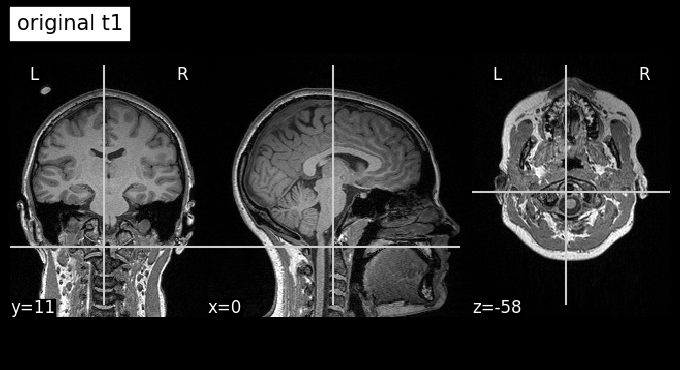

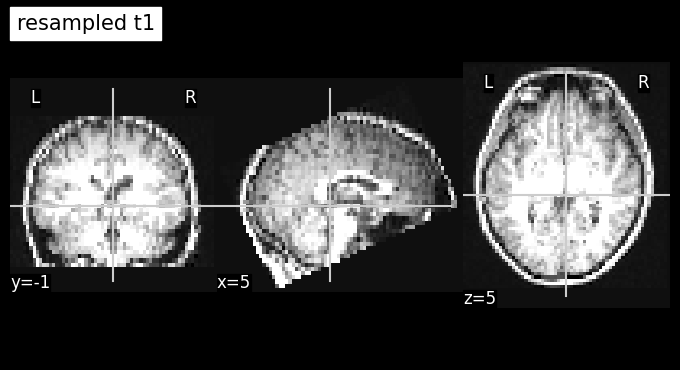

In [77]:
%matplotlib inline

plotting.plot_anat(t1_img, title = 'original t1', dim=-1)
plotting.plot_anat(resampled_t1, title = 'resampled t1', dim=-1)

### 3.3. <a id='toc3_3_'></a>[Smooth an image](#toc0_)

Using `smooth_img`, we can quickly smooth any type of MRI image. For example, let's take the mean image from above and apply smoothing with different FWHM values.

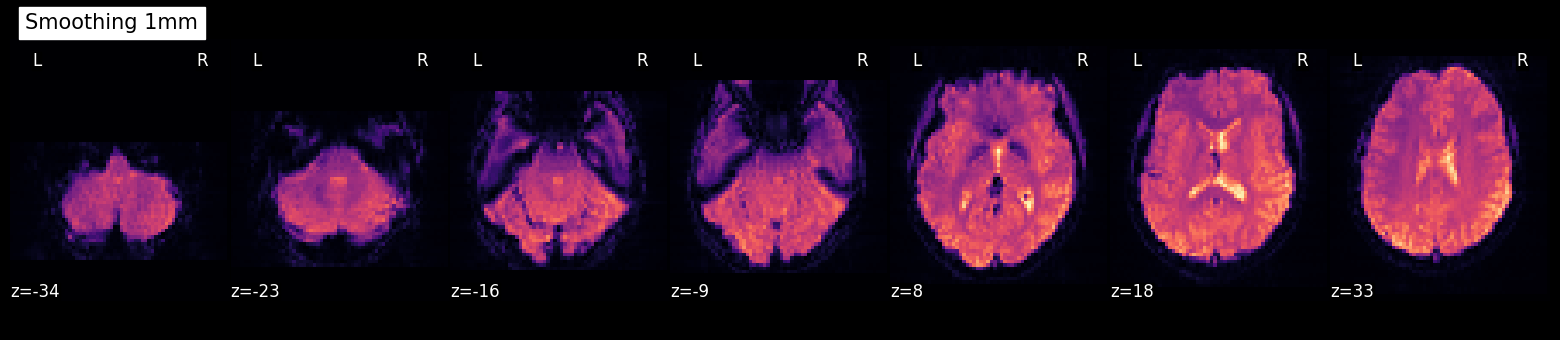

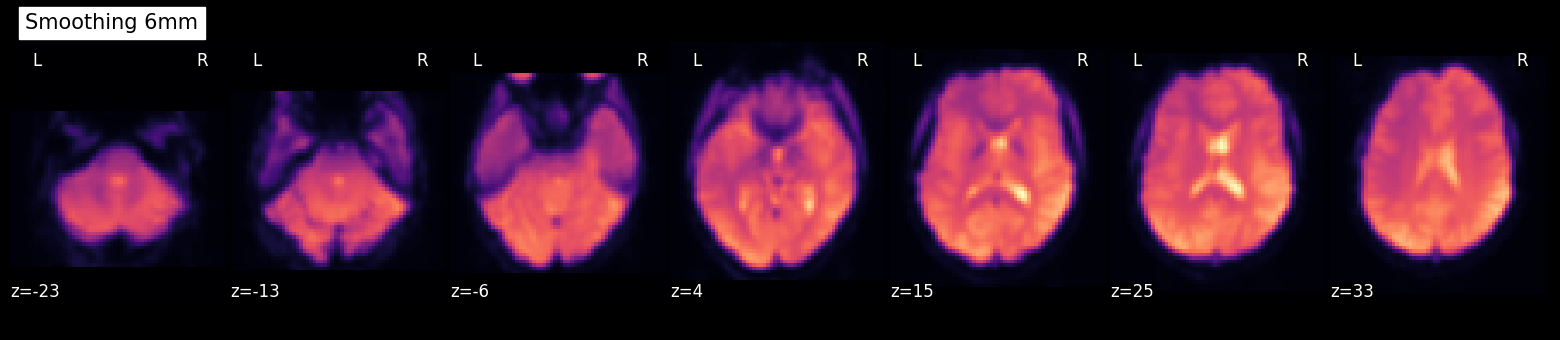

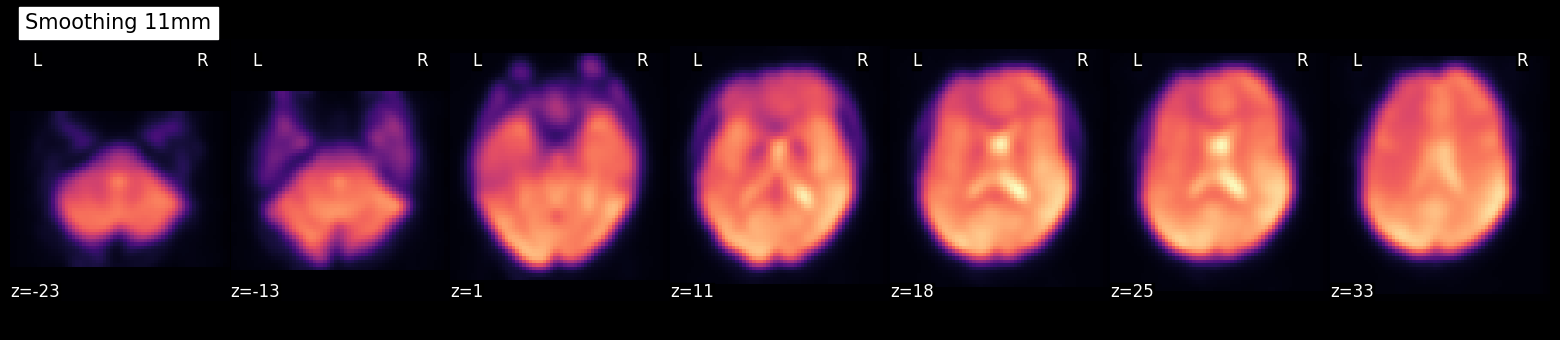

In [78]:
for fwhm in range(1, 12, 5):
    smoothed_img = nli.smooth_img(mean_img, fwhm)
    plotting.plot_epi(smoothed_img, title="Smoothing %imm" % fwhm,
                     display_mode='z', cmap='magma')

### 3.4. <a id='toc3_4_'></a>[Plotting a time course](#toc0_)

Let's plot a time course of the central voxel in our BOLD imgage and some other random voxel.  

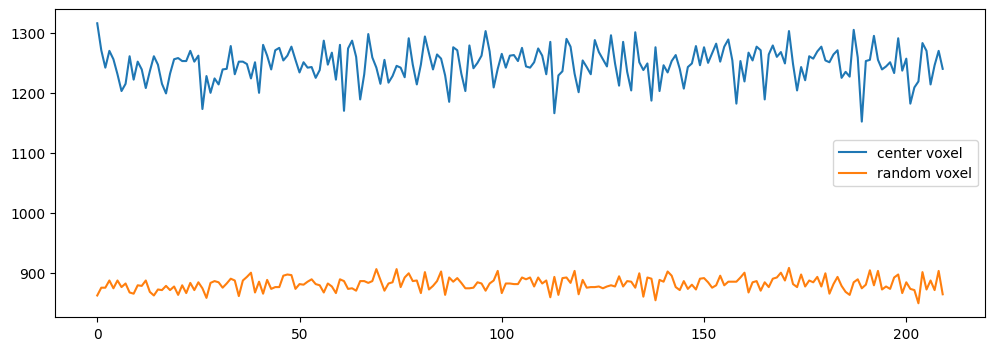

In [79]:
# get the xyz of the center 
bold_vox_center = (np.array(bold_data.shape) - 1) / 2.
x, y, z, _ = bold_vox_center

# set the plot size
plt.figure(figsize=(12, 4))

# plot the central voxel time course
plt.plot(bold_data[int(x), int(y), int(z), :])

# plot some random voxel time course
plt.plot(bold_data[28, 45, 15, :])

# add legends to the plot
plt.legend(['center voxel', 'random voxel']);

Alternatively, we can use Nilearn's *NiftiSpheresMasker* function, which allows us to extract time series from a single voxel or a sphere around it. The input coordinates, in this case, must be in **world coordinates**.

In [80]:
# Translate the two previously used voxel coordinates to the world coordinates
bold_center_coords = apply_affine(bold_img.affine, [x, y, z])
print(f"The center of the BOLD image in the world coordinates is {bold_center_coords}")

random_voxel_coords = apply_affine(bold_img.affine, [28, 45, 15])
print(f"The random voxel in the BOLD image in the world coordinates is {random_voxel_coords}")

The center of the BOLD image in the world coordinates is [ 5.568  7.061 22.373]
The random voxel in the BOLD image in the world coordinates is [16.068 45.555 35.552]


In [81]:
# Extract the time series of the center and random voxels
from nilearn.maskers import NiftiSpheresMasker

coord_masker = NiftiSpheresMasker(
    [bold_center_coords, random_voxel_coords], t_r=2
)
coord_time_series = coord_masker.fit_transform(bold_img)

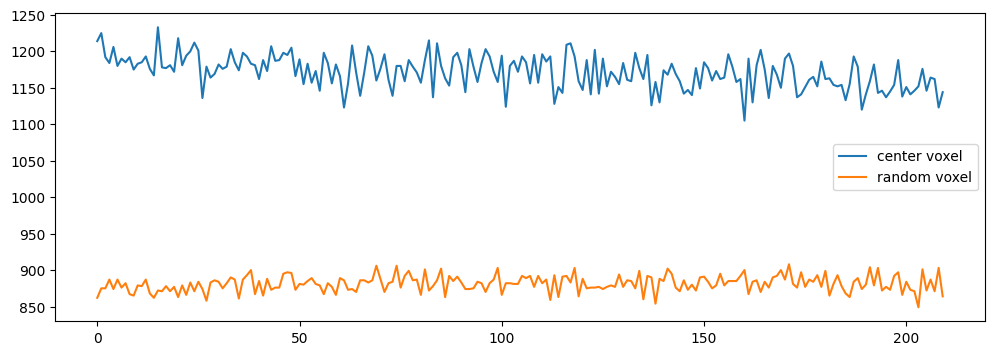

In [82]:
# Plot the time series of the center and random voxels
plt.figure(figsize=(12, 4))
plt.plot(coord_time_series)
plt.legend(['center voxel', 'random voxel'])

### 3.5. <a id='toc3_5_'></a>[Masking an image](#toc0_)

Let's take our BOLD functional image, compute its mean image, and apply a threshold to keep only the voxels with values higher than 95% of all voxels.

In [ ]:
#create the mean image
mean_img = nli.mean_img(bold_img)

#keep voxels that have a value that is higher than 95% of all voxels
thr = nli.threshold_img(mean_img, threshold='95%')

#let's see how the thresholded image look compared to the original mean image
plotting.view_img(thr, bg_img=mean_img)